# Group 22 C18-S3 Capstone Project Computational Analysis 

In [2]:
# Import necessary libraries
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime as dt
import random
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.util.testing import assert_frame_equal
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


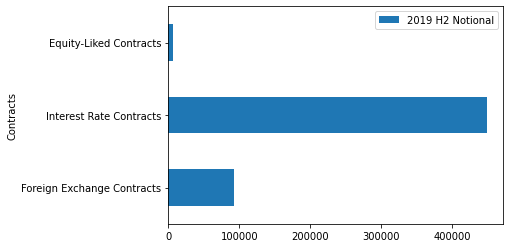

In [3]:
#Bar Plots of OTC Data

#Data summarised from https://stats.bis.org/statx/srs/table/d5.1

otc_derivatives = pd.DataFrame([['Foreign Exchange Contracts', 92177], ['Interest Rate Contracts',  448965], ['Equity-Liked Contracts',  6874]], columns = ["Contracts", "2019 H2 Notional"])  


ax = otc_derivatives.plot.barh("Contracts","2019 H2 Notional")
plt.legend()
#print(otc_derivatives) 

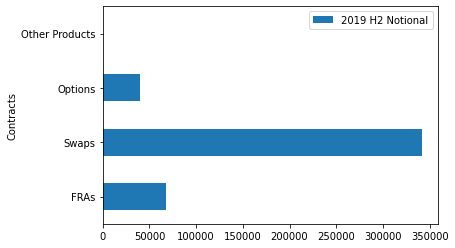

In [4]:
# Bar plots of Interest Rate Derivatives Data

##Data summarised from https://stats.bis.org/statx/srs/table/d5.1

ir_contracts = pd.DataFrame([['FRAs', 67431], ['Swaps',  341292], ['Options',  39916], ['Other Products',  326]], columns = ["Contracts", "2019 H2 Notional"])  

ax = ir_contracts.plot.barh("Contracts","2019 H2 Notional")


In [0]:

# Data for 3 MONTH LIBOR ON USD 
# load data from FRED API & save copy locally to CSV file for Three Month LIBOR on US Dollar
try:
    start = dt.datetime(2018, 1, 1)
    end = dt.datetime(2020, 1, 27)

    three_mth_libor = web.DataReader("USD3MTD156N", "fred", start, end)

    #three_mth_libor.to_csv('cap_data/3_MT_LIBOR.csv') # commented out for upload to github
    
except Exception as e:
    print(e)



In [6]:
three_mth_libor.head()

USD3MTD156N
DATE                   
2018-01-01          NaN
2018-01-02      1.69693
2018-01-03      1.69593
2018-01-04      1.70381
2018-01-05      1.70393

In [7]:
three_mth_libor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541 entries, 2018-01-01 to 2020-01-27
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   USD3MTD156N  524 non-null    float64
dtypes: float64(1)
memory usage: 8.5 KB


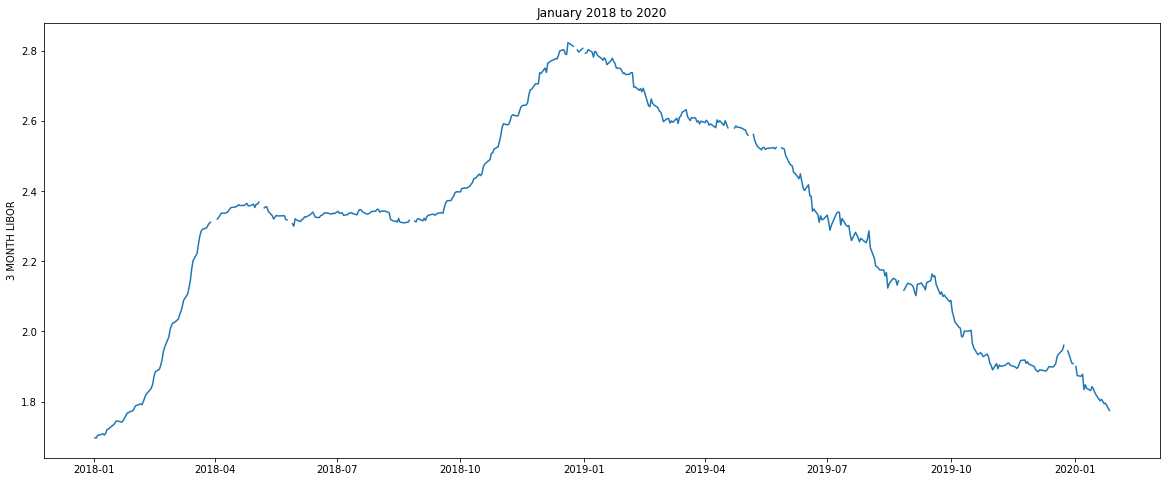

In [8]:
# Plot the time series

plt.figure(figsize=(20,8))

plt.plot(three_mth_libor)
plt.ylabel("3 MONTH LIBOR")
plt.title("January 2018 to 2020")
#plt.savefig('cap_image/3mthlibor_run_chart.png')
plt.show()


In [9]:
# Mean and Standard Deviation
three_mth_libor_mean = three_mth_libor.mean()
three_mth_libor_std = three_mth_libor.std()
print('mean =',three_mth_libor_mean)
print('Std deviation =',three_mth_libor_std)

mean = USD3MTD156N    2.3002
dtype: float64
Std deviation = USD3MTD156N    0.297252
dtype: float64


In [10]:
three_mth_libor.kurtosis()

USD3MTD156N   -0.858473
dtype: float64

In [0]:
# Helper function that calculates the next rate based on the discretization
  # of the Varice model. 
  #
  # Args: 
  #   r: The interest rate used to generate the next interest rate.
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   dt: The change in time between observations. Defaults to 1/252 because
  #       we assume generation of daily rates and there are 252 trading days 
  #       per year. 
  #
  # Returns:
#   A vector of simulated short rates. 

def VasicekNextRate(r, kappa, theta, sigma, dt=1/252):
    # Implements above closed form solution     
    val1 = np.exp(-1*kappa*dt)
    val2 = (sigma**2)*(1-val1**2) / (2*kappa)
    out = r*val1 + theta*(1-val1) + (np.sqrt(val2))*np.random.normal()
    return out


In [0]:
# Generates a single short rate simulation using the Vasicek model.
  #
  # Args: 
  #   N: The number of points to generate in each simulation. For example, 
  #      the number of days when simulating daily rates.
  #   r0: The initial interest rate. 
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   dt: The change in time between observations. Defaults to 1/252 because
  #       we assume generation of daily rates and there are 252 trading days 
  #       per year. 
  #
  # Returns:
#   A vector of simulated short rates.


def VasicekSim(N, r0, kappa, theta, sigma, dt = 1/252):
    short_r = [0]*N # Create array to store rates     short_r[0] = r0 # Initialise rates at $r_0$     
    
    for i in range(1,N):
        short_r[i] = VasicekNextRate(short_r[i-1], kappa, theta, sigma, dt)
    
    return short_r


In [0]:

# Generates several short rate simulations using the Vasicek model.
  #
  # Args: 
  #   M: The number of simulations to run. 
  #   N: The number of points to generate in each simulation. For example, 
  #      the number of days when simulating daily rates.
  #   r0: The initial interest rate. 
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   dt: The change in time between observations. Defaults to 1/252 because
  #       we assume generation of daily rates and there are 252 trading days 
  #       per year. 
  #
  # Returns:
#   An N row by M column matrix of simulated short rates. 

def VasicekMultiSim(M, N, r0, kappa, theta, sigma, dt = 1/252):
    sim_arr = np.ndarray((N, M))
    
    for i in range(0,M):
        sim_arr[:, i] = VasicekSim(N, r0, kappa, theta, sigma, dt)
    
    return sim_arr

In [0]:
## Calculates the zero coupon bond price. 
  #
  # Args: 
  #   r0: The initial interest rate. 
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   years: The length or maturity of the bond.  
  #
  # Returns:
  #   A decimal price of the bond (i.e. 0.98 for 98). 
def VasicekZeroCouponBondPrice(r0, kappa, theta, sigma, years):
    b_vas = (1-np.exp(-years*kappa)) / kappa
    a_vas = (theta-sigma**2/(2*kappa**2))*(years-b_vas)+(sigma**2)/(4*kappa)*b_vas**2
    bond_price = np.exp(-a_vas-b_vas*r0)
    return bond_price
    

In [0]:
# Produces a yield curve from the Vasicek model with maturities ranging 
  # from 1 year to max.maturity.  
  #
  # Args: 
  #   r0: The initial interest rate. 
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   max.maturity: Maximum maturity in years (must be integer).
  #
  # Returns:
  #   A list of decimal prices of the bond (i.e. 0.98 for 98). 
    
def VasicekYieldCurve(r0, kappa, theta, sigma, max_maturity=10):
    yields = np.zeros(max_maturity) #rep(0,max_maturity)
    for y in range(0,max_maturity):
        yields[y] = -np.log(VasicekZeroCouponBondPrice(r0, kappa, theta, sigma, y))/y
    return yields

In [0]:
#zero bond curve

def VasicekBondCurve(r0, kappa, theta, sigma, max_maturity=10):
    bonds = np.zeros(max_maturity) #rep(0,max_maturity)
    for y in range(0,max_maturity):
        bonds[y] = VasicekZeroCouponBondPrice(r0, kappa, theta, sigma, y)/y
    return bonds

In [0]:

#
  # Calibrates the vasicek model using the maximum likelihood estimator. 
  #
  # Args:
  #   rates: rates from the market timeseries
  #   dt: The change in time between observations. Defaults to 1/252 because
  #       we assume generation of daily rates and there are 252 trading days 
  #       per year. 
  #
  # Returns:
  #   A vector of the form c(kappa, theta, sigma, r0), where kappa is the mean
  #   reversion rate, theta is the long-term rate/mean, sigma is the volatility
  #   and r0 is the last observed rate.
#

def VasicekCalibration(rates, dt=1/252):
    n = len(rates)
    
    # Implement MLE to calibrate parameters     
    Sx = sum(rates[0:(n-1)])
    Sy = sum(rates[1:n])
    Sxx = np.dot(rates[0:(n-1)], rates[0:(n-1)])
    Sxy = np.dot(rates[0:(n-1)], rates[1:n])
    Syy = np.dot(rates[1:n], rates[1:n])
    
    theta = (Sy * Sxx - Sx * Sxy) / (n * (Sxx - Sxy) - (Sx**2 - Sx*Sy))
    kappa = -np.log((Sxy - theta * Sx - theta * Sy + n * theta**2) / (Sxx - 2*theta*Sx + n*theta**2)) / dt
    a = np.exp(-kappa * dt)
    sigmah2 = (Syy - 2*a*Sxy + a**2 * Sxx - 2*theta*(1-a)*(Sy - a*Sx) + n*theta**2 * (1-a)**2) / n
    sigma = np.sqrt(sigmah2*2*kappa / (1-a**2))
    r0 = rates[n-1]
    
    return [kappa, theta, sigma, r0]


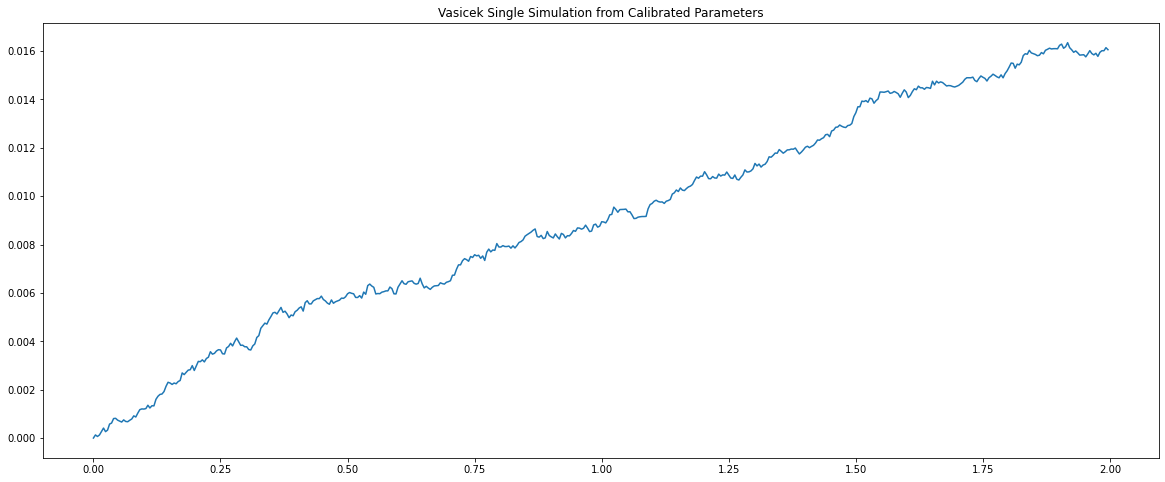

In [18]:
#define model parameters based on the three month libor data

params = VasicekCalibration(three_mth_libor.iloc[:, 0].dropna()/100) 
kappa = params[0]
theta = params[1]
sigma = params[2]
r0 = params[3]



years = 2
N = years * 252
t = np.arange(0,N)/252

#
random.seed(1)

three_mth_libor_test_sim = VasicekSim(N, r0, kappa, theta, sigma, 1/252)
plt.figure(figsize=(20,8))
plt.plot(t,three_mth_libor_test_sim)
#plt.figure(figsize=(20,8))
plt.title("Vasicek Single Simulation from Calibrated Parameters")

#plt.savefig('cap_image/vasicek_single_run_chart.png')
plt.show()


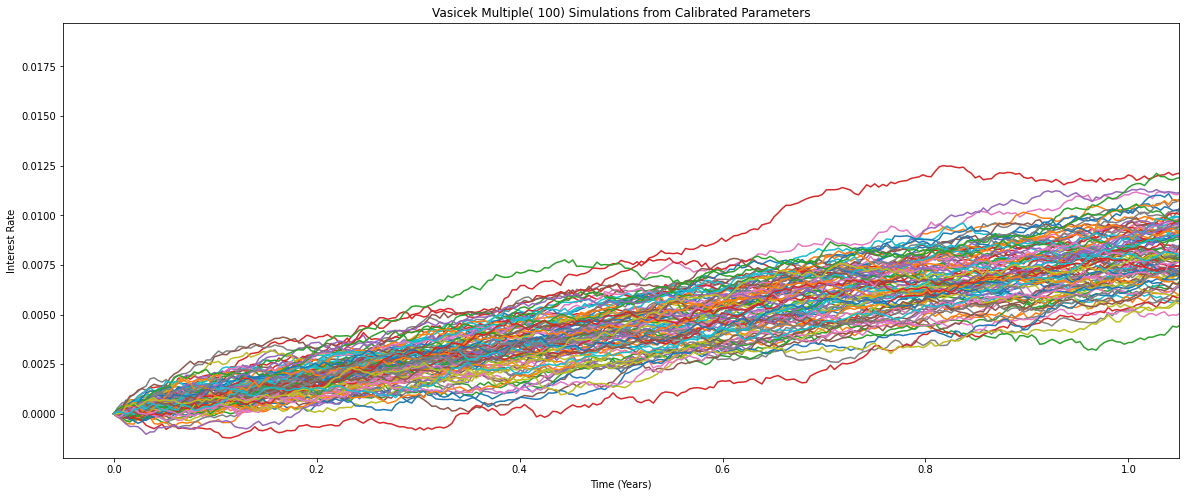

In [19]:
M = 100
random.seed(1)
three_mth_libor_rates_arr = VasicekMultiSim(M, N, r0, kappa, theta, sigma)

plt.figure(figsize=(20,8))
plt.plot(t,three_mth_libor_rates_arr)
#plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
#plt.annotate('Theta', xy=(1.0, theta+0.0005))
plt.xlim(-0.05, 1.05)
plt.ylabel("Interest Rate")
plt.xlabel("Time (Years)")
plt.title("Vasicek Multiple( 100) Simulations from Calibrated Parameters")
#plt.savefig('cap_image/vasicek_multiple_run_chart.png')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


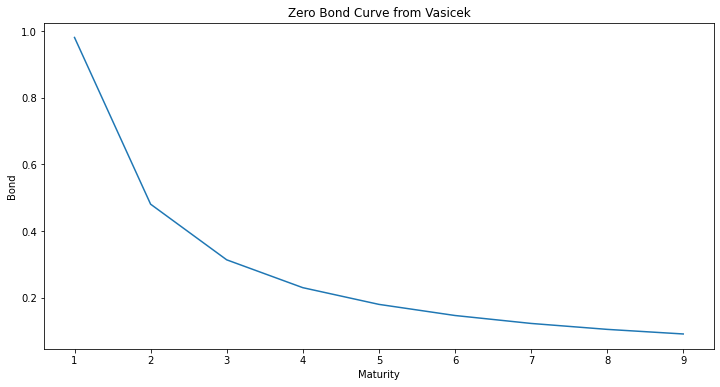

In [20]:

# derive a bond curve 
# (can do this for several values of r0 to get several curves)
#r0 = three_mth_libor.iloc[-1:, 0].dropna()/100
three_mth_libor_bonds = VasicekBondCurve(r0, kappa, theta, sigma, 10)
T = np.arange(0,10)

plt.figure(figsize=(12,6))
plt.plot(T,three_mth_libor_bonds)
plt.title("Zero Bond Curve from Vasicek")
plt.ylabel("Bond")
plt.xlabel("Maturity")


#plt.savefig('cap_image/Zero_Bond_Curve_chart.png')
plt.show()

In [21]:
print(three_mth_libor_bonds)

[       inf 0.98136151 0.48073734 0.31364618 0.23003683 0.17987167
 0.14645631 0.12262738 0.10479823 0.09097335]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


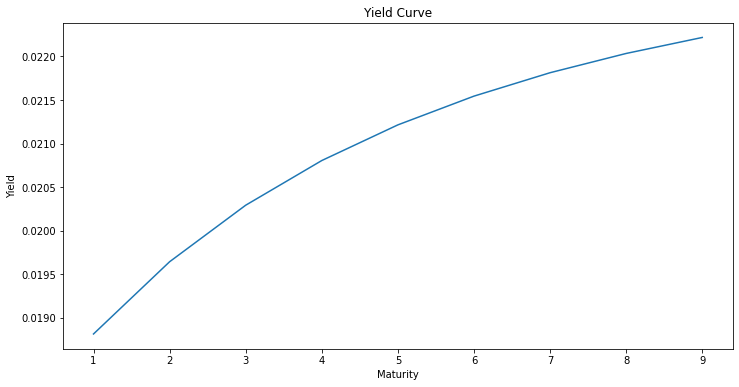

In [22]:
# derive a yield curve 
# (can do this for several values of r0 to get several curves)
#r0 = three_mth_libor.iloc[-1:, 0].dropna()/100
three_mth_libor_yields = VasicekYieldCurve(r0, kappa, theta, sigma, 10)
T = np.arange(0,10)

plt.figure(figsize=(12,6))
plt.plot(T,three_mth_libor_yields)
plt.title("Yield Curve")
plt.ylabel("Yield")
plt.xlabel("Maturity")

#plt.savefig('cap_image/vasicek_Yield_Curve_chart.png')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


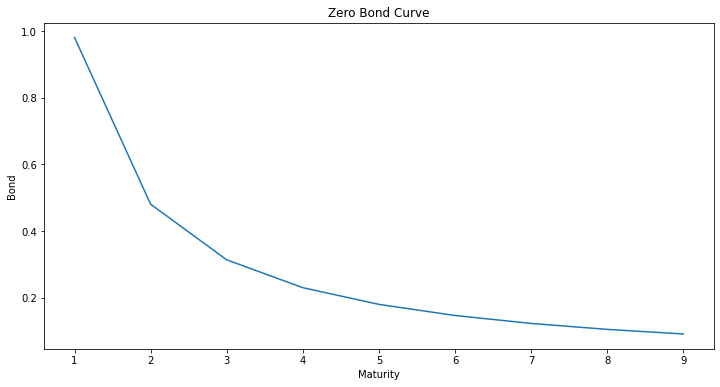

In [23]:

# derive a bond curve 
# (can do this for several values of r0 to get several curves)
#r0 = three_mth_libor.iloc[-1:, 0].dropna()/100
three_mth_libor_yields = VasicekBondCurve(r0, kappa, theta, sigma, 10)
T = np.arange(0,10)

plt.figure(figsize=(12,6))
plt.plot(T,three_mth_libor_yields)
plt.title("Zero Bond Curve")
plt.ylabel("Bond")
plt.xlabel("Maturity")
plt.show()


In [0]:
# load data from FRED API & save copy locally to CSV file for 10-Year Treasury Constant Maturity Rate
try:
    start = dt.datetime(2018, 1, 1)
    end = dt.datetime(2020, 1, 27)

    ten_yr_treasury = web.DataReader("DGS10", "fred", start, end)
    #ten_yr_treasury.to_csv('cap_data/ten_yr_treasury.csv')
    
except Exception as e:
    print(e)


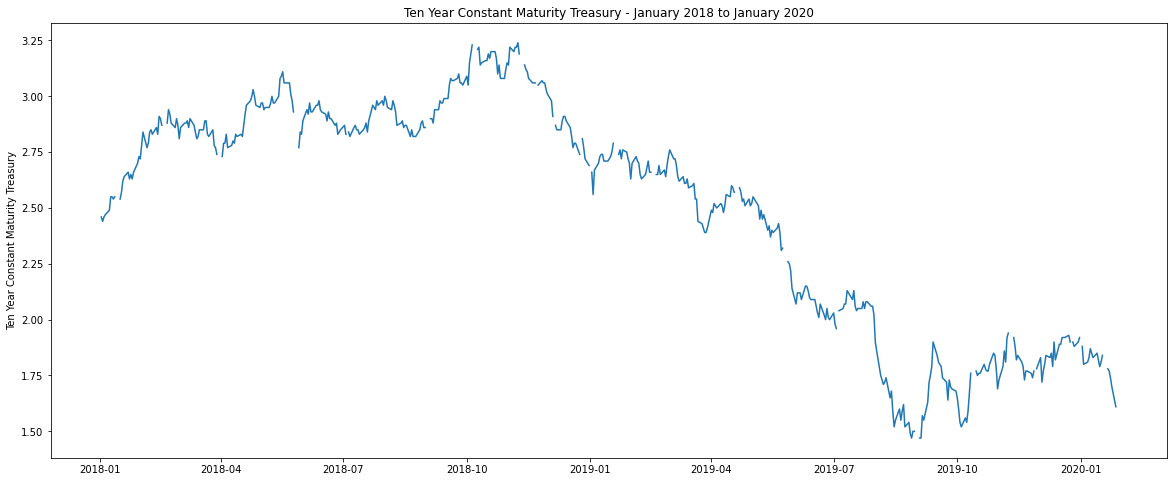

In [25]:
# Plot the time series

plt.figure(figsize=(20,8))
plt.plot(ten_yr_treasury)
plt.ylabel("Ten Year Constant Maturity Treasury")
plt.title("Ten Year Constant Maturity Treasury - January 2018 to January 2020")
#plt.savefig('cap_image/ten_yr_treasury_run_chart.png')
plt.show()


In [26]:
# Mean and Standard Deviation
treasury_mean = ten_yr_treasury.mean()
treasury_std = ten_yr_treasury.std()
print('mean =',treasury_mean)
print('Std deviation =',treasury_std)

mean = DGS10    2.501609
dtype: float64
Std deviation = DGS10    0.50048
dtype: float64


In [27]:
ten_yr_treasury.kurtosis()

DGS10   -1.118714
dtype: float64

In [0]:
#The Vasicel Simulation and Modelling Code

In [0]:
####
# Based on R script for simulationg bond short rates with the Vasicek model. It includes
# functions to calibrate the Vasicek model, run simulations and derive yield
# curves. 
##https://clinthoward.github.io/portfolio/2017/08/19/Rates-Simulations/

In [0]:
# Helper function that calculates the next rate based on the discretization
  # of the Varice model. 
  #
  # Args: 
  #   r: The interest rate used to generate the next interest rate.
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   dt: The change in time between observations. Defaults to 1/252 because
  #       we assume generation of daily rates and there are 252 trading days 
  #       per year. 
  #
  # Returns:
#   A vector of simulated short rates. 

def VasicekNextRate(r, kappa, theta, sigma, dt=1/252):
    # Implements above closed form solution     
    val1 = np.exp(-1*kappa*dt)
    val2 = (sigma**2)*(1-val1**2) / (2*kappa)
    out = r*val1 + theta*(1-val1) + (np.sqrt(val2))*np.random.normal()
    return out


In [0]:
# Generates a single short rate simulation using the Vasicek model.
  #
  # Args: 
  #   N: The number of points to generate in each simulation. For example, 
  #      the number of days when simulating daily rates.
  #   r0: The initial interest rate. 
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   dt: The change in time between observations. Defaults to 1/252 because
  #       we assume generation of daily rates and there are 252 trading days 
  #       per year. 
  #
  # Returns:
#   A vector of simulated short rates.


def VasicekSim(N, r0, kappa, theta, sigma, dt = 1/252):
    short_r = [0]*N # Create array to store rates     short_r[0] = r0 # Initialise rates at $r_0$     
    
    for i in range(1,N):
        short_r[i] = VasicekNextRate(short_r[i-1], kappa, theta, sigma, dt)
    
    return short_r


In [0]:
# Generates several short rate simulations using the Vasicek model.
  #
  # Args: 
  #   M: The number of simulations to run. 
  #   N: The number of points to generate in each simulation. For example, 
  #      the number of days when simulating daily rates.
  #   r0: The initial interest rate. 
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   dt: The change in time between observations. Defaults to 1/252 because
  #       we assume generation of daily rates and there are 252 trading days 
  #       per year. 
  #
  # Returns:
#   An N row by M column matrix of simulated short rates. 

def VasicekMultiSim(M, N, r0, kappa, theta, sigma, dt = 1/252):
    sim_arr = np.ndarray((N, M))
    
    for i in range(0,M):
        sim_arr[:, i] = VasicekSim(N, r0, kappa, theta, sigma, dt)
    
    return sim_arr


In [0]:
## Calculates the zero coupon bond price. 
  #
  # Args: 
  #   r0: The initial interest rate. 
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   years: The length or maturity of the bond.  
  #
  # Returns:
  #   A decimal price of the bond (i.e. 0.98 for 98). 
def VasicekZeroCouponBondPrice(r0, kappa, theta, sigma, years):
    b_vas = (1-np.exp(-years*kappa)) / kappa
    a_vas = (theta-sigma**2/(2*kappa**2))*(years-b_vas)+(sigma**2)/(4*kappa)*b_vas**2
    bond_price = np.exp(-a_vas-b_vas*r0)
    return bond_price
    

In [0]:
# Produces a yield curve from the Vasicek model with maturities ranging 
  # from 1 year to max.maturity.  
  #
  # Args: 
  #   r0: The initial interest rate. 
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   max.maturity: Maximum maturity in years (must be integer).
  #
  # Returns:
  #   A decimal price of the bond (i.e. 0.98 for 98). 
    
def VasicekYieldCurve(r0, kappa, theta, sigma, max_maturity=10):
    yields = np.zeros(max_maturity) #rep(0,max_maturity)
    for y in range(0,max_maturity):
        yields[y] = -np.log(VasicekZeroCouponBondPrice(r0, kappa, theta, sigma, y))/y
    return yields

In [0]:
#zero bond curve

def VasicekBondCurve(r0, kappa, theta, sigma, max_maturity=10):
    bonds = np.zeros(max_maturity) #rep(0,max_maturity)
    for y in range(0,max_maturity):
        bonds[y] = VasicekZeroCouponBondPrice(r0, kappa, theta, sigma, y)/y
    return bonds

In [0]:
#
  # Calibrates the vasicek model using the maximum likelihood estimator. Details
  # about the maximum likelihood extomator are at the link below. 
  #
  # Args:
  #   fred.ticker: Ticker used to download the historical rates from the Federal
  #                Reserve Bank of St Louis. Defaults to DSG3MO, the 3-Month 
  #                Treasury Constant Maturity Rate. 
  #   dt: The change in time between observations. Defaults to 1/252 because
  #       we assume generation of daily rates and there are 252 trading days 
  #       per year. 
  #
  # Returns:
  #   A vector of the form c(kappa, theta, sigma, r0), where kappa is the mean
  #   reversion rate, theta is the long-term rate/mean, sigma is the volatility
  #   and r0 is the last observed rate.
#

def VasicekCalibration(rates, dt=1/252):
    n = len(rates)
    
    # Implement MLE to calibrate parameters     
    Sx = sum(rates[0:(n-1)])
    Sy = sum(rates[1:n])
    Sxx = np.dot(rates[0:(n-1)], rates[0:(n-1)])
    Sxy = np.dot(rates[0:(n-1)], rates[1:n])
    Syy = np.dot(rates[1:n], rates[1:n])
    
    theta = (Sy * Sxx - Sx * Sxy) / (n * (Sxx - Sxy) - (Sx**2 - Sx*Sy))
    kappa = -np.log((Sxy - theta * Sx - theta * Sy + n * theta**2) / (Sxx - 2*theta*Sx + n*theta**2)) / dt
    a = np.exp(-kappa * dt)
    sigmah2 = (Syy - 2*a*Sxy + a**2 * Sxx - 2*theta*(1-a)*(Sy - a*Sx) + n*theta**2 * (1-a)**2) / n
    sigma = np.sqrt(sigmah2*2*kappa / (1-a**2))
    r0 = rates[n-1]
    
    return [kappa, theta, sigma, r0]

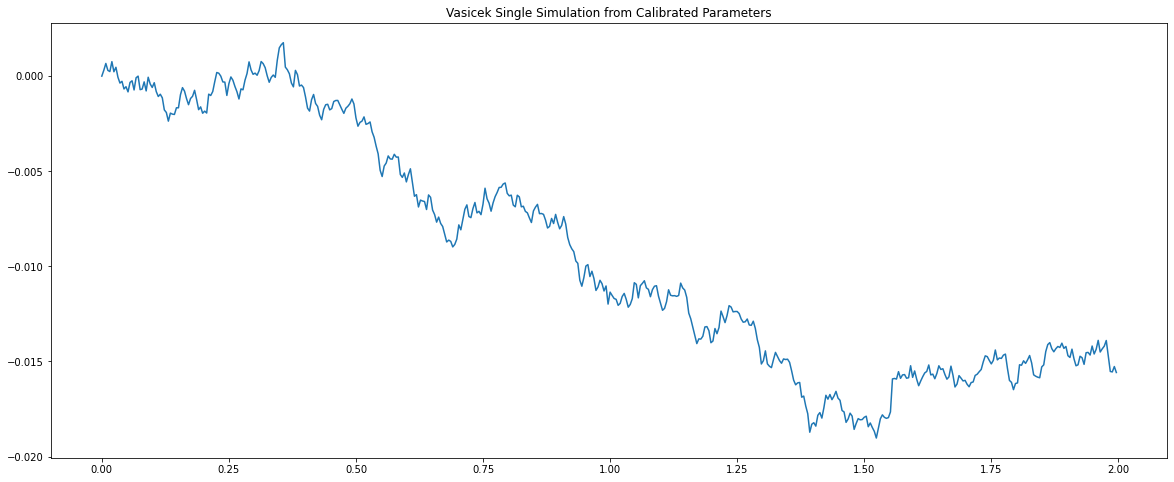

In [37]:
#define model parameters

params = VasicekCalibration(ten_yr_treasury.iloc[:, 0].dropna()/100) #df. iloc[:, 0]
kappa = params[0]
theta = params[1]
sigma = params[2]
r0 = params[3]



years = 2
N = years * 252
t = np.arange(0,N)/252

#
random.seed(1)

treasury_test_sim = VasicekSim(N, r0, kappa, theta, sigma, 1/252)
plt.figure(figsize=(20,8))
plt.plot(t,treasury_test_sim)
#plt.figure(figsize=(20,8))
plt.title("Vasicek Single Simulation from Calibrated Parameters")

#plt.savefig('cap_image/treasury_ten_vasicek_single_run_chart.png')
plt.show()


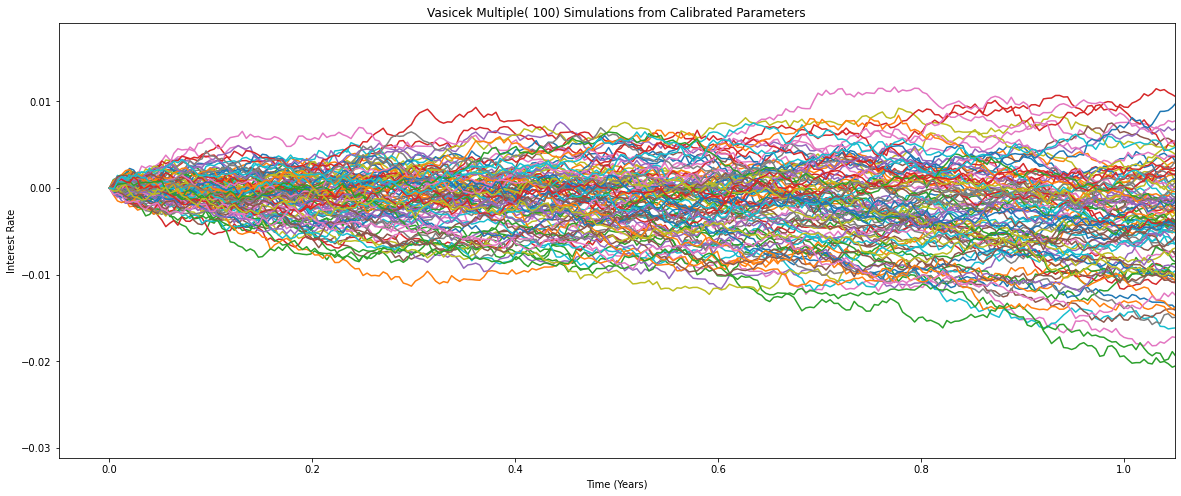

In [38]:
M = 100
random.seed(1)
treasury_rates_arr = VasicekMultiSim(M, N, r0, kappa, theta, sigma)

plt.figure(figsize=(20,8))
plt.plot(t,treasury_rates_arr)
#plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
#plt.annotate('Theta', xy=(1.0, theta+0.0005))
plt.xlim(-0.05, 1.05)
plt.ylabel("Interest Rate")
plt.xlabel("Time (Years)")
plt.title("Vasicek Multiple( 100) Simulations from Calibrated Parameters")
#plt.savefig('cap_image/treasury_ten_vasicek_multiple_run_chart.png')
plt.show()


In [39]:

# price the zero coupon bonds 
VasicekZeroCouponBondPrice(r0, kappa, theta, sigma, years) 

0.9761486913884366

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


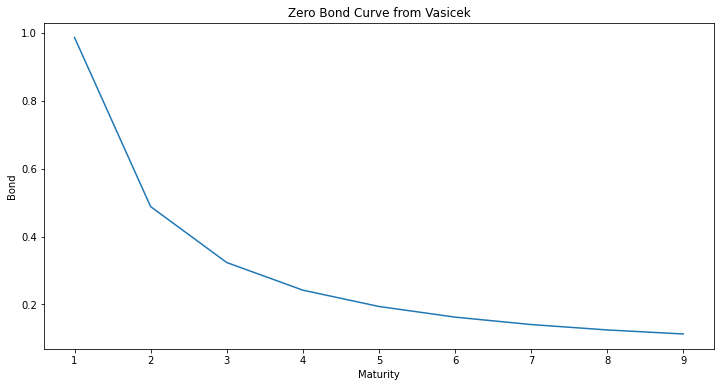

In [40]:

# derive a bond curve 
# (can do this for several values of r0 to get several curves)
#r0 = three_mth_libor.iloc[-1:, 0].dropna()/100
treasury_bonds = VasicekBondCurve(r0, kappa, theta, sigma, 10)
T = np.arange(0,10)

plt.figure(figsize=(12,6))
plt.plot(T,treasury_bonds)
plt.title("Zero Bond Curve from Vasicek")
plt.ylabel("Bond")
plt.xlabel("Maturity")


#plt.savefig('cap_image/treasury_ten_Zero_Bond_Curve_chart.png')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


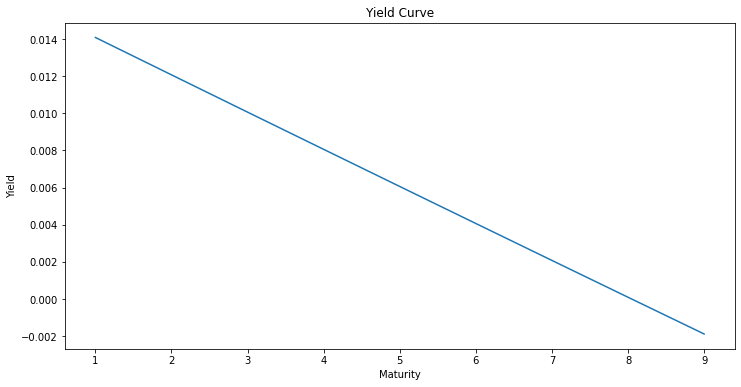

In [41]:
# derive a yield curve 
# (can do this for several values of r0 to get several curves)
#r0 = three_mth_libor.iloc[-1:, 0].dropna()/100
treasury_yields = VasicekYieldCurve(r0, kappa, theta, sigma, 10)
T = np.arange(0,10)

plt.figure(figsize=(12,6))
plt.plot(T,treasury_yields)
plt.title("Yield Curve")
plt.ylabel("Yield")
plt.xlabel("Maturity")

#plt.savefig('cap_image/treasury_ten_vasicek_Yield_Curve_chart.png')
plt.show()

In [0]:

# load data from FRED API & save copy locally to CSV file for 10-Year ICE Swap Rate
try:
    start = dt.datetime(2018, 1, 1)
    end = dt.datetime(2020, 1, 27)

    ten_yr_swap_rate = web.DataReader("ICERATES1100USD10Y", "fred", start, end)
    #ten_yr_treasury.to_csv('cap_data/ten_yr_treasury.csv')
    
except Exception as e:
    print(e)


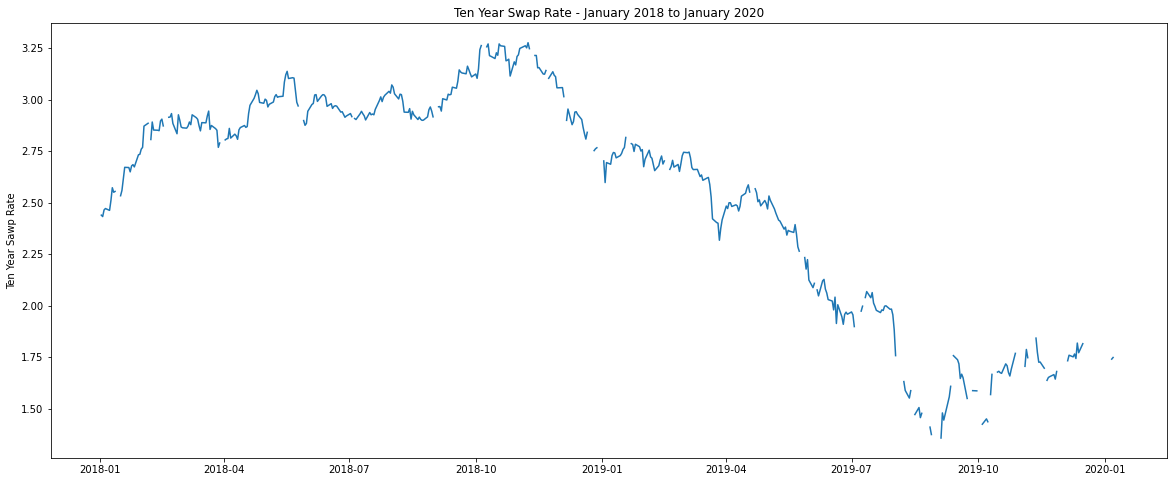

In [43]:
# Plot the time series

plt.figure(figsize=(20,8))
plt.plot(ten_yr_swap_rate)
plt.ylabel("Ten Year Sawp Rate")
plt.title("Ten Year Swap Rate - January 2018 to January 2020")
#plt.savefig('cap_image/ten_yr_swap_rate_chart.png')
plt.show()


In [44]:
# Mean and Standard Deviation
swap_mean = ten_yr_swap_rate.mean()
swap_std = ten_yr_swap_rate.std()
print('mean =',swap_mean)
print('Std deviation =',swap_std)

mean = ICERATES1100USD10Y    2.587848
dtype: float64
Std deviation = ICERATES1100USD10Y    0.510609
dtype: float64


In [45]:
ten_yr_swap_rate.kurtosis()

ICERATES1100USD10Y   -0.574348
dtype: float64

In [0]:
# Helper function that calculates the next rate based on the discretization
  # of the Varice model. 
  #
  # Args: 
  #   r: The interest rate used to generate the next interest rate.
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   dt: The change in time between observations. Defaults to 1/252 because
  #       we assume generation of daily rates and there are 252 trading days 
  #       per year. 
  #
  # Returns:
#   A vector of simulated short rates. 

def VasicekNextRate(r, kappa, theta, sigma, dt=1/252):
    # Implements above closed form solution     
    val1 = np.exp(-1*kappa*dt)
    val2 = (sigma**2)*(1-val1**2) / (2*kappa)
    out = r*val1 + theta*(1-val1) + (np.sqrt(val2))*np.random.normal()
    return out


In [0]:
# Generates a single short rate simulation using the Vasicek model.
  #
  # Args: 
  #   N: The number of points to generate in each simulation. For example, 
  #      the number of days when simulating daily rates.
  #   r0: The initial interest rate. 
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   dt: The change in time between observations. Defaults to 1/252 because
  #       we assume generation of daily rates and there are 252 trading days 
  #       per year. 
  #
  # Returns:
#   A vector of simulated short rates.


def VasicekSim(N, r0, kappa, theta, sigma, dt = 1/252):
    short_r = [0]*N # Create array to store rates     short_r[0] = r0 # Initialise rates at $r_0$     
    
    for i in range(1,N):
        short_r[i] = VasicekNextRate(short_r[i-1], kappa, theta, sigma, dt)
    
    return short_r

In [0]:
# Generates several short rate simulations using the Vasicek model.
  #
  # Args: 
  #   M: The number of simulations to run. 
  #   N: The number of points to generate in each simulation. For example, 
  #      the number of days when simulating daily rates.
  #   r0: The initial interest rate. 
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   dt: The change in time between observations. Defaults to 1/252 because
  #       we assume generation of daily rates and there are 252 trading days 
  #       per year. 
  #
  # Returns:
#   An N row by M column matrix of simulated short rates. 

def VasicekMultiSim(M, N, r0, kappa, theta, sigma, dt = 1/252):
    sim_arr = np.ndarray((N, M))
    
    for i in range(0,M):
        sim_arr[:, i] = VasicekSim(N, r0, kappa, theta, sigma, dt)
    
    return sim_arr

In [0]:
## Calculates the zero coupon bond price. 
  #
  # Args: 
  #   r0: The initial interest rate. 
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   years: The length or maturity of the bond.  
  #
  # Returns:
  #   A decimal price of the bond (i.e. 0.98 for 98). 
def VasicekZeroCouponBondPrice(r0, kappa, theta, sigma, years):
    b_vas = (1-np.exp(-years*kappa)) / kappa
    a_vas = (theta-sigma**2/(2*kappa**2))*(years-b_vas)+(sigma**2)/(4*kappa)*b_vas**2
    bond_price = np.exp(-a_vas-b_vas*r0)
    return bond_price

In [0]:
# Produces a yield curve from the Vasicek model with maturities ranging 
  # from 1 year to max.maturity.  
  #
  # Args: 
  #   r0: The initial interest rate. 
  #   kappa: The mean reversion rate. 
  #   theta: The mean rate or long term rate. 
  #   sigma: Volatility. 
  #   max.maturity: Maximum maturity in years (must be integer).
  #
  # Returns:
  #   A decimal price of the bond (i.e. 0.98 for 98). 
    
def VasicekYieldCurve(r0, kappa, theta, sigma, max_maturity=10):
    yields = np.zeros(max_maturity) #rep(0,max_maturity)
    for y in range(0,max_maturity):
        yields[y] = -np.log(VasicekZeroCouponBondPrice(r0, kappa, theta, sigma, y))/y
    return yields

In [0]:
#zero bond curve

def VasicekBondCurve(r0, kappa, theta, sigma, max_maturity=10):
    bonds = np.zeros(max_maturity) #rep(0,max_maturity)
    for y in range(0,max_maturity):
        bonds[y] = VasicekZeroCouponBondPrice(r0, kappa, theta, sigma, y)/y
    return bonds

In [0]:
#
  # Calibrates the vasicek model using the maximum likelihood estimator. Details
  # about the maximum likelihood extomator are at the link below. 
  #
  #  
  #
  # Args:
  #   fred.ticker: Ticker used to download the historical rates from the Federal
  #                Reserve Bank of St Louis. Defaults to DSG3MO, the 3-Month 
  #                Treasury Constant Maturity Rate. 
  #   dt: The change in time between observations. Defaults to 1/252 because
  #       we assume generation of daily rates and there are 252 trading days 
  #       per year. 
  #
  # Returns:
  #   A vector of the form c(kappa, theta, sigma, r0), where kappa is the mean
  #   reversion rate, theta is the long-term rate/mean, sigma is the volatility
  #   and r0 is the last observed rate.
#

def VasicekCalibration(rates, dt=1/252):
    n = len(rates)
    
    # Implement MLE to calibrate parameters     
    Sx = sum(rates[0:(n-1)])
    Sy = sum(rates[1:n])
    Sxx = np.dot(rates[0:(n-1)], rates[0:(n-1)])
    Sxy = np.dot(rates[0:(n-1)], rates[1:n])
    Syy = np.dot(rates[1:n], rates[1:n])
    
    theta = (Sy * Sxx - Sx * Sxy) / (n * (Sxx - Sxy) - (Sx**2 - Sx*Sy))
    kappa = -np.log((Sxy - theta * Sx - theta * Sy + n * theta**2) / (Sxx - 2*theta*Sx + n*theta**2)) / dt
    a = np.exp(-kappa * dt)
    sigmah2 = (Syy - 2*a*Sxy + a**2 * Sxx - 2*theta*(1-a)*(Sy - a*Sx) + n*theta**2 * (1-a)**2) / n
    sigma = np.sqrt(sigmah2*2*kappa / (1-a**2))
    r0 = rates[n-1]
    
    return [kappa, theta, sigma, r0]

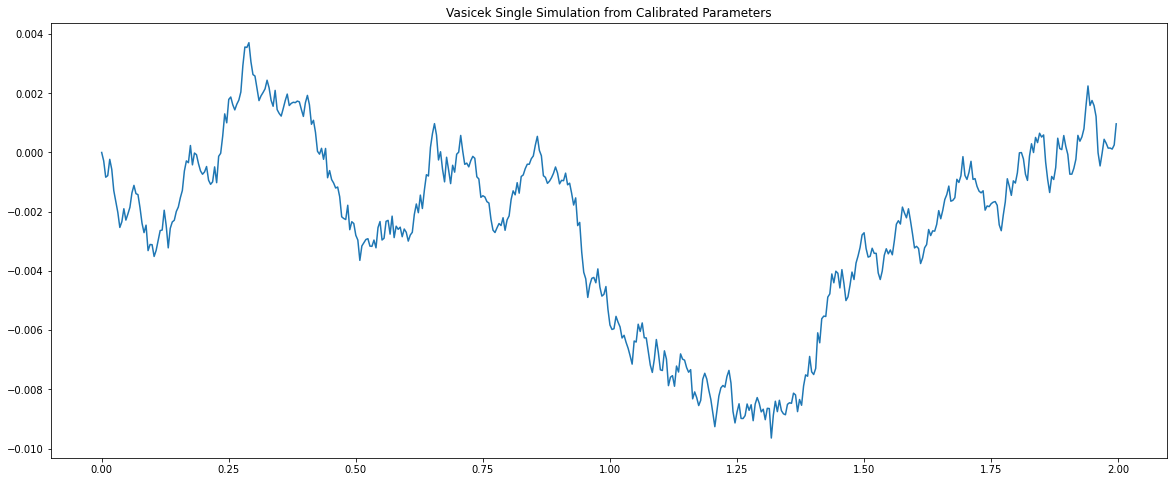

In [53]:
#define model parameters through calibration of live data
params = VasicekCalibration(ten_yr_swap_rate.iloc[:, 0].dropna()/100) #df. iloc[:, 0]
kappa = params[0]
theta = params[1]
sigma = params[2]
r0 = params[3]



years = 2
N = years * 252
t = np.arange(0,N)/252

#
random.seed(1)

swap_test_sim = VasicekSim(N, r0, kappa, theta, sigma, 1/252)
plt.figure(figsize=(20,8))
plt.plot(t,swap_test_sim)
#plt.figure(figsize=(20,8))
plt.title("Vasicek Single Simulation from Calibrated Parameters")

#plt.savefig('cap_image/treasury_ten_vasicek_single_run_chart.png')
plt.show()

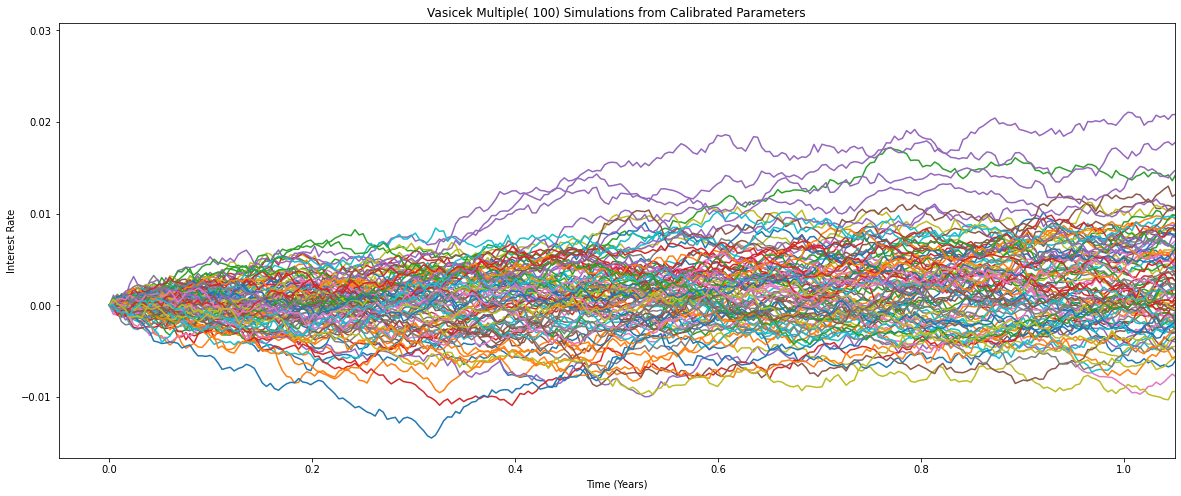

In [54]:
M = 100
random.seed(1)
swap_rates_arr = VasicekMultiSim(M, N, r0, kappa, theta, sigma)

plt.figure(figsize=(20,8))
plt.plot(t,swap_rates_arr)
#plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
#plt.annotate('Theta', xy=(1.0, theta+0.0005))
plt.xlim(-0.05, 1.05)
plt.ylabel("Interest Rate")
plt.xlabel("Time (Years)")
plt.title("Vasicek Multiple( 100) Simulations from Calibrated Parameters")
#plt.savefig('cap_image/treasury_ten_vasicek_multiple_run_chart.png')
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


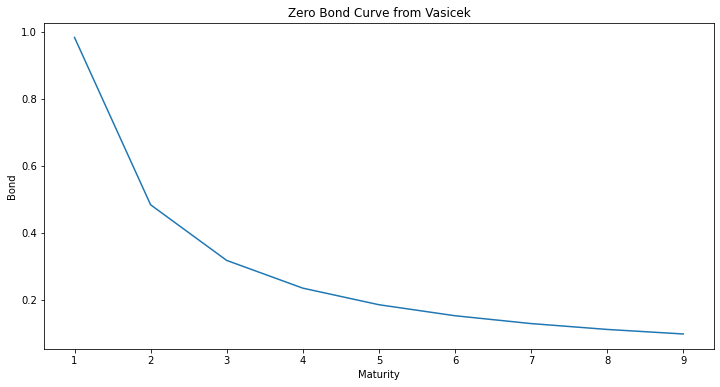

In [55]:

# derive a bond curve 
# (can do this for several values of r0 to get several curves)
#r0 = three_mth_libor.iloc[-1:, 0].dropna()/100
swap_bonds = VasicekBondCurve(r0, kappa, theta, sigma, 10)
T = np.arange(0,10)

plt.figure(figsize=(12,6))
plt.plot(T,swap_bonds)
plt.title("Zero Bond Curve from Vasicek")
plt.ylabel("Bond")
plt.xlabel("Maturity")


#plt.savefig('cap_image/treasury_ten_Zero_Bond_Curve_chart.png')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


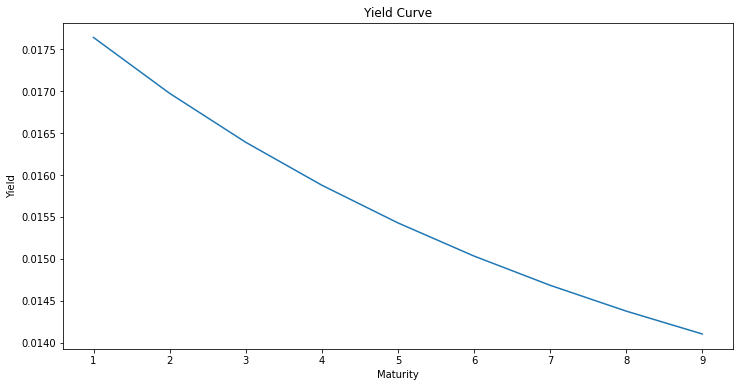

In [56]:
# derive a yield curve 
# (can do this for several values of r0 to get several curves)
#r0 = three_mth_libor.iloc[-1:, 0].dropna()/100
swap_yields = VasicekYieldCurve(r0, kappa, theta, sigma, 10)
T = np.arange(0,10)

plt.figure(figsize=(12,6))
plt.plot(T,swap_yields)
plt.title("Yield Curve")
plt.ylabel("Yield")
plt.xlabel("Maturity")

#plt.savefig('cap_image/treasury_ten_vasicek_Yield_Curve_chart.png')
plt.show()

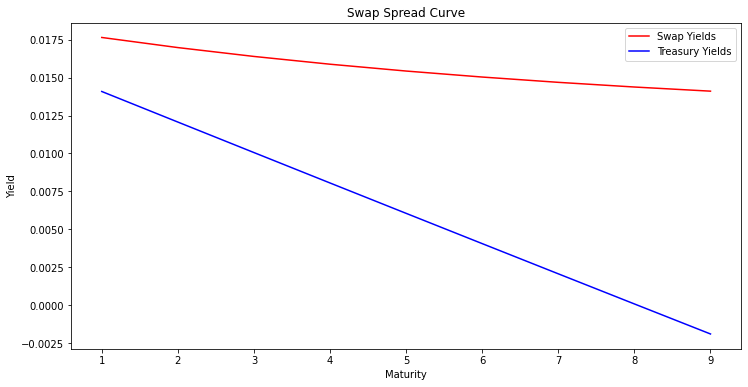

In [57]:
# derive a swap spread curve 
# 


plt.figure(figsize=(12,6))
plt.plot(T, swap_yields, color="red", label= "Swap Yields")
plt.plot(T, treasury_yields, color = "blue", label ="Treasury Yields")
plt.title("Swap Spread Curve")
plt.ylabel("Yield")
plt.xlabel("Maturity")
plt.legend()

#plt.savefig('cap_image/treasury_ten_vasicek_Yield_Curve_chart.png')
plt.show()

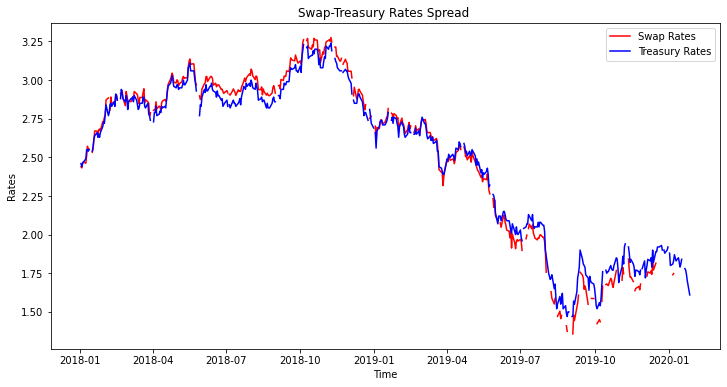

In [58]:
# Plot treasury and swap rates
plt.figure(figsize=(12,6))
plt.plot(ten_yr_swap_rate, color="red", label= "Swap Rates")
plt.plot(ten_yr_treasury, color = "blue", label ="Treasury Rates")
plt.title("Swap-Treasury Rates Spread ")
plt.ylabel("Rates")
plt.xlabel("Time")
plt.legend()

#plt.savefig('cap_image/treasury_ten_rates_Curve_chart.png')
plt.show()

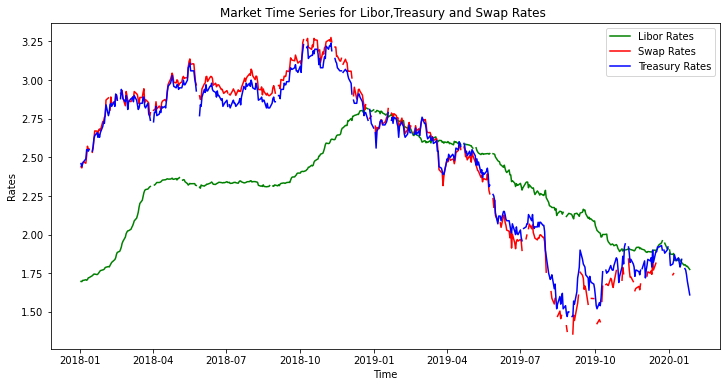

In [59]:
# Plot libor, treasury and swap rates
plt.figure(figsize=(12,6))
plt.plot(three_mth_libor, color="green", label= "Libor Rates")
plt.plot(ten_yr_swap_rate, color="red", label= "Swap Rates")
plt.plot(ten_yr_treasury, color = "blue", label ="Treasury Rates")
plt.title("Market Time Series for Libor,Treasury and Swap Rates ")
plt.ylabel("Rates")
plt.xlabel("Time")
plt.legend()

#plt.savefig('cap_image/all_rates_Curve_chart.png')
plt.show()

In [67]:
# Table for Kurtosis
series_kurtosis = pd.DataFrame([['Three Month LIBOR', three_mth_libor.kurtosis()], ['Ten Year Treasury',  ten_yr_treasury.kurtosis()], ['Ten Year Swap ',  ten_yr_swap_rate.kurtosis()]], columns = ["Interest Rates", "Kurtosis"])  


print(series_kurtosis)


      Interest Rates                                       Kurtosis
0  Three Month LIBOR         USD3MTD156N   -0.858473
dtype: float64
1  Ten Year Treasury               DGS10   -1.118714
dtype: float64
2     Ten Year Swap   ICERATES1100USD10Y   -0.574348
dtype: float64
